# Notes

concept categorization (data, how to define on topic models?)

# Data

* Latest Wikipedia corpus
* Extracted plain text
* Only used first 1000 words per document
* 87,380,300 sentences
* 1,813,672,600 words, 9,996,018 unique words

## topic model training
* Using mallet
* 256 topics, 400 iterations, 13 hours

## word2vec training
* skip-gram model in gensim
* 3.5 hours
* remove words occurring less than 50 times --> 386,046 words unique words (98 % of original corpus)


# Setup

In [1]:
%matplotlib notebook

import itertools
from functools import partial
import numpy as np
import gensim, logging
import pandas as pnd
from sklearn.cluster import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, RandomizedPCA
import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
from IPython.core.display import HTML
HTML("""
<style>
div.text_cell_render p, div.text_cell_render ul, table.dataframe {
font-size:1.3em;
line-height:1.1em;
}
</style>
""")

# Preprocessing

## Topic model

In [13]:
# Prepare data in long form

df_topics = pnd.read_csv("../models/topic-models/topic.full.fixed-vocabulary.alpha-1-100.256-400.model.ssv",
                         sep=" ")
df_topics = df_topics.ix[:,-10:]
df_topics.columns = list(range(10))
df_topics["topic"] =  df_topics.index
df_topics["topic_name"] = df_topics[0]

df = pnd.melt(df_topics, id_vars=["topic", "topic_name"], var_name="position", value_name="word")
df = df[["word", "topic", "topic_name", "position"]]
df = df.sort_values(by=["topic", "position"]).reset_index(drop=True)
df[df.topic == 0]

,word,topic,topic_name,position
0,would,0,would,0
1,time,0,would,1
2,new,0,would,2
3,first,0,would,3
4,however,0,would,4
5,years,0,would,5
6,could,0,would,6
7,later,0,would,7
8,one,0,would,8
9,made,0,would,9


## Word embeddings

In [40]:
WORD2VEC_VECTOR_FILE = "/home/knub/Repositories/master-thesis/models/word-embeddings/GoogleNews-vectors-negative300.bin"
GLOVE_VECTOR_FILE = "/home/knub/Repositories/master-thesis/models/word-embeddings/glove.6B.50d.txt"
CBOW_VECTOR_FILE = "/home/knub/Repositories/master-thesis/models/word-embeddings/embedding.model.cbow"
SKIP_GRAM_VECTOR_FILE = "/home/knub/Repositories/master-thesis/models/word-embeddings/embedding.model.skip-gram"

#vectors_glove = gensim.models.Word2Vec.load_word2vec_format(GLOVE_VECTOR_FILE, binary=False)
#vectors_skip = gensim.models.Word2Vec.load_word2vec_format(SKIP_GRAM_VECTOR_FILE, binary=True)
#vectors_cbow = gensim.models.Word2Vec.load_word2vec_format(CBOW_VECTOR_FILE, binary=True)
vectors_word2vec = gensim.models.Word2Vec.load_word2vec_format(WORD2VEC_VECTOR_FILE, binary=True)
vectors_default = vectors_word2vec

In [42]:
def get_data_frame_from_word_vectors(df_param, vectors):
    df_param = df_param[df_param["word"].apply(lambda word: word in vectors)]    
    df_param["embeddings"] = df_param["word"].apply(lambda word: vectors[word])
    return df_param

df = get_data_frame_from_word_vectors(df.copy(), vectors_default)
df[df.topic == 0]

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,word,topic,topic_name,position,embeddings
0,would,0,would,0,"[0.0893555, 0.129883, 0.212891, 0.177734, -0.1..."
1,time,0,would,1,"[-0.0473633, 0.1875, 0.0022583, 0.173828, -0.0..."
2,new,0,would,2,"[0.0112915, 0.0289307, 0.0834961, -0.0498047, ..."
3,first,0,would,3,"[0.122559, -0.0893555, 0.0269775, 0.0737305, 0..."
4,however,0,would,4,"[0.150391, 0.0412598, -0.0654297, 0.102051, -0..."
5,years,0,would,5,"[-0.126953, 0.208984, -0.106445, 0.0471191, -0..."
6,could,0,would,6,"[0.123535, 0.0319824, 0.150391, 0.152344, -0.0..."
7,later,0,would,7,"[0.188477, -0.173828, 0.15332, 0.0556641, 0.23..."
8,one,0,would,8,"[0.0456543, -0.145508, 0.15625, 0.166016, 0.10..."
9,made,0,would,9,"[-0.0559082, 0.117676, 0.210938, 0.00836182, 0..."


In [43]:
# financial, muslim, teams in sport, atom physics, math
nice_topics = [5, 117, 158, 164, 171]
nice_topics = [0, 7, 236]

df_part = df[df.topic.apply(lambda topic: topic in nice_topics)].copy()
# Show topics of interest
df_tmp = pnd.DataFrame(df_part.groupby("topic")["word"].apply(lambda l: l.tolist()).tolist())
df_tmp.index = nice_topics
df_tmp

,0,1,2,3,4,5,6,7,8,9
0,would,time,new,first,however,years,could,later,one,made
7,village,town,area,population,district,located,local,parish,road,church
236,san,california,santa,francisco,diego,mexico,valley,county,state,city


## Dimensionality reduction

In [44]:
def pca(embeddings, n=2):
    pca = RandomizedPCA(n_components=n)
    return pca.fit_transform(embeddings)

def tsne(embeddings):
    tsne = TSNE(n_components=2)
    return tsne.fit_transform(embeddings)

def tsne_with_init_pca(embeddings):
    tsne = TSNE(n_components=2, init="pca")
    return tsne.fit_transform(embeddings)

# Topic model in word embedding space

## Plot preparation

In [45]:
def plot_topics_in_embedding_space(reduction_method, df_param):
    embeddings = np.array(df_param["embeddings"].tolist())
    X = reduction_method(embeddings)
    df_tmp = df_param.copy()
    df_tmp["x"] = X[:,0]
    df_tmp["y"] = X[:,1]
    df_tmp = df_tmp[df_tmp.topic.apply(lambda topic: topic in nice_topics)]
    colors = {0: "red", 7: "blue", 236: "green", 164: "yellow", 171: "black"}
    plt.figure(figsize=(12, 8))
    plt.scatter(df_tmp.x, df_tmp.y, c=df_tmp.topic.apply(lambda topic: colors[topic]), s=80)
    
    ylim = plt.gca().get_ylim()
    step = (ylim[1] - ylim[0]) / 100
    
    for index, row in df_tmp.iterrows():
        plt.text(row.x, row.y - step, row.word, horizontalalignment='center', verticalalignment='top')

## PCA

In [46]:
#plot_topics_in_embedding_space(pca, df)

<IPython.core.display.Javascript object>


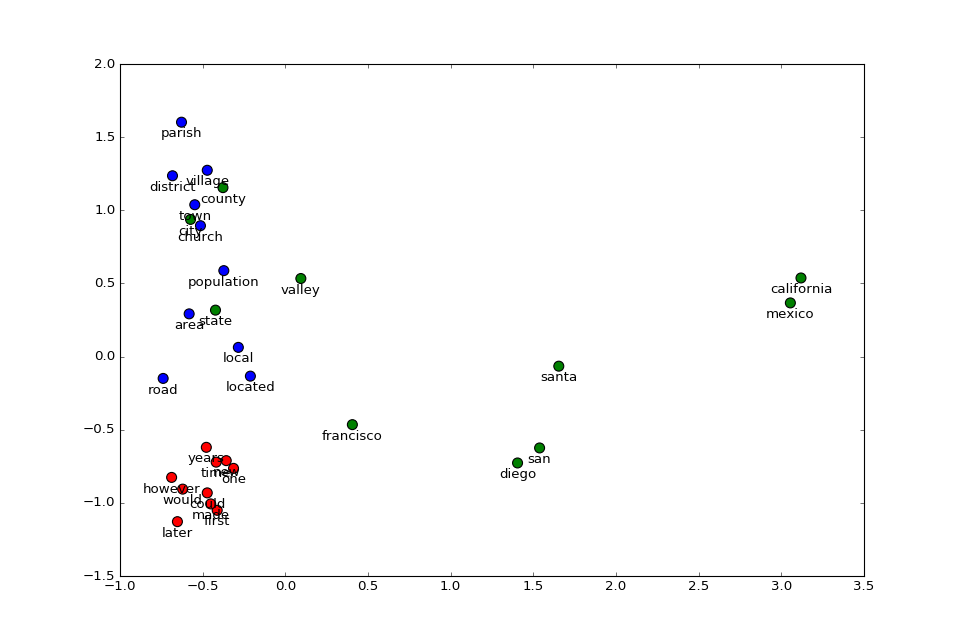

In [47]:
plot_topics_in_embedding_space(pca, df_part) # third dimensions

## t-SNE

In [ ]:
#plot_topics_in_embedding_space(tsne, df)

## t-SNE with PCA initialization

<IPython.core.display.Javascript object>


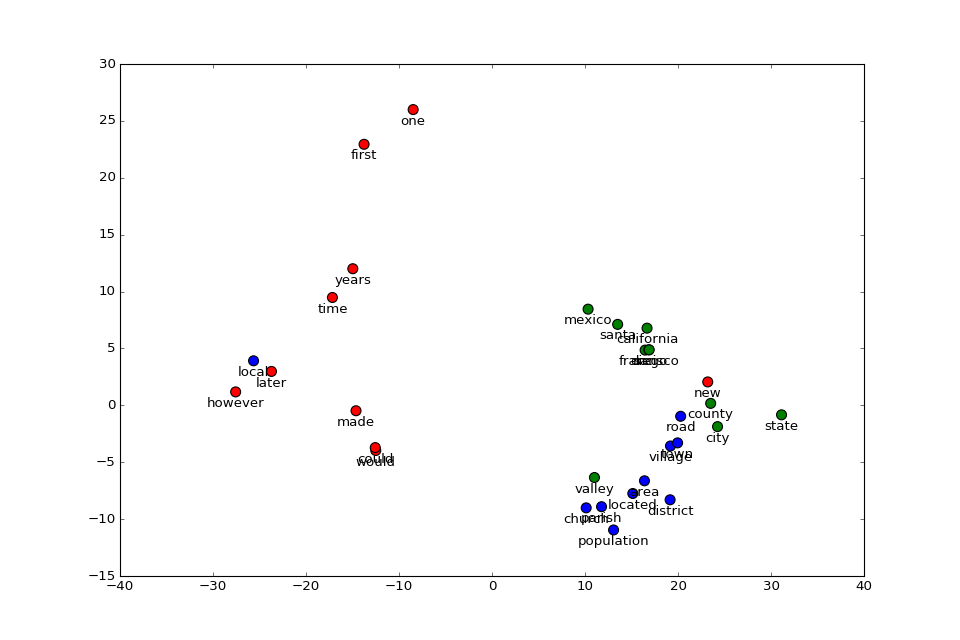

In [22]:
plot_topics_in_embedding_space(tsne_with_init_pca, df)

## Findings

Topics from the topic model do not seem to be in similar positions in the vector space, in general.

* **Specifity**: The more specific a word is, the closer it is to similar words in the word embedding space. See the "muslim", "islam", "mohammad" cluster.
* **Ambiguity**: Ambiguous words are a special problem, for example "current" is far away from the other physic terms because it has too many meanings. In fact, it is very close to the word "new".
* **Context-based similarity**: Topic models can assign different similarities between words based on the context. They are good at finding similar words in a context, which might not be immediately obvious. Example: "distribution" is not very similar to "function", however in the company of "mean", "probability", "data", "random" it is. See also "Exploring the Space of Topic Coherence Measures" by Röder et al.

# Word embedding similarity of topics 

## Avg. pairwise similarity

In [48]:
def average_pairwise_similarity(words, vectors):
    word_pairs = itertools.permutations(words, 2)
    similarities = [vectors.similarity(word1, word2) for word1, word2 in word_pairs if word1 < word2]
    return np.mean(similarities)

def average_top_similarity(words, vectors):
    word_pairs = itertools.permutations(words, 2)
    similarities = [(word1, vectors.similarity(word1, word2)) for word1, word2 in word_pairs]
    max_similarities = [max([s for w, s in l]) for _, l in itertools.groupby(similarities, lambda s: s[0])]
    return np.mean(max_similarities)

In [49]:
topic_lengths = list(range(2, 11))
def calculate_similarities_for_topic(df_topic, sim_function, vectors):
    words_in_topic = df_topic["word"].tolist()
    
    average_similarities = [sim_function(words_in_topic[:topic_length], vectors)
                            for topic_length in topic_lengths]
    
    return pnd.Series(average_similarities)

def calculate_similarity_matrix(sim_function, vectors):
    def partial_function(df_topic):
        return calculate_similarities_for_topic(df_topic, sim_function, vectors)

    df_similarities = df.groupby("topic").apply(partial_function)
    df_similarities.columns = ["%s-words" % i for i in topic_lengths]
    return df_similarities

In [50]:
df_similarities = calculate_similarity_matrix(average_pairwise_similarity, vectors_default)
df_similarities.mean()

2-words     0.341394
3-words     0.324044
4-words     0.309233
5-words     0.292517
6-words     0.282898
7-words     0.271561
8-words     0.264227
9-words     0.257879
10-words    0.248975
dtype: float64

<IPython.core.display.Javascript object>


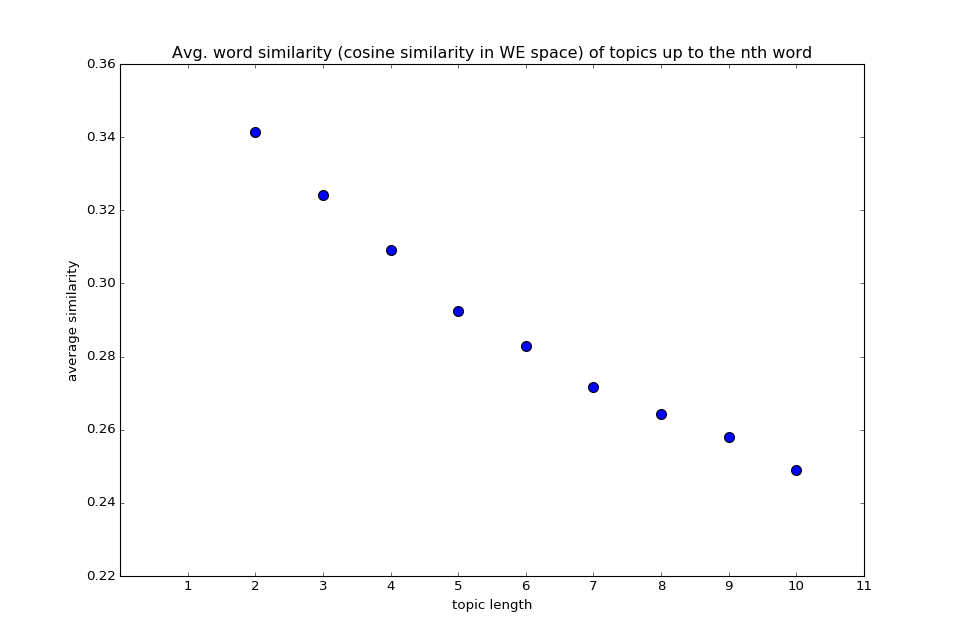

In [51]:
means = df_similarities.mean().tolist()
plt.figure(figsize=(12, 8))
plt.scatter(topic_lengths, means, s=80)
plt.title("Avg. word similarity (cosine similarity in WE space) of topics up to the nth word")
plt.xlim(0, 11)
plt.xticks(list(range(1, 12)))
#plt.ylim((0, 0.35))
plt.xlabel("topic length")
plt.ylabel("average similarity")

## Highest-similar topics

For comparison, here are a few standard similarities:

**king-prince**: {{vectors_default.similarity("king", "prince")}}
**king-queen**: {{vectors_default.similarity("king", "queen")}}
**topic-topics**: {{vectors_default.similarity("topic", "topics")}}
**buy-purchase**: {{vectors_default.similarity("buy", "purchase")}}

In [52]:
def show_highest_similar_topics(topic_length, nr_topics=3):
    column = "%s-words" % topic_length
    df_top = df_similarities.sort_values(by=column, ascending=False)[:nr_topics]
    return df_top.join(df_topics)[[column] + list(range(topic_length))]

In [53]:
show_highest_similar_topics(3)

,3-words,0,1,2
topic,,,,
44,0.733276,song,songs,album
198,0.665253,animals,animal,dog
249,0.657131,store,stores,mall


In [54]:
show_highest_similar_topics(6)

,6-words,0,1,2,3,4,5
topic,,,,,,,
180,0.567653,university,college,students,campus,student,school
231,0.562334,israel,jewish,israeli,jerusalem,palestinian,jews
77,0.553442,music,opera,orchestra,symphony,composer,piano


In [55]:
show_highest_similar_topics(10)

,10-words,0,1,2,3,4,5,6,7,8,9
topic,,,,,,,,,,,
193,0.497805,greek,serbian,greece,serbia,croatian,bulgarian,croatia,bosnia,yugoslavia,bulgaria
76,0.470207,church,bishop,catholic,saint,diocese,roman,cathedral,pope,archbishop,priest
111,0.444010,texas,chicago,illinois,michigan,state,city,kansas,minnesota,iowa,missouri


## Findings

* In general, similarity is not very high after the first few words, when comparing against usual similarities
* Again, topics with highly specific words have highest WE similarity

# Concept categorization in TM and WE

In [79]:
def get_embedding_from_word_embedding(word):
    try:
        return vectors_default[word]
    except:
        return vectors_default["this"]

columns = [str(i) for i in range(256)]
def get_embedding_from_topics(word):
    df_row = df_topic_probs[df_topic_probs["word"] == word]
    assert len(df_row) == 1, "more than one row found"
    df_row[columns].tolist()
    return None

def get_df_concept(embedding_function):
    df_concept = pnd.read_csv(
        "/home/knub/Repositories/master-thesis/data/concept-categorization/battig_concept-categorization.tsv",
        sep="\t",
        header=None)
    df_concept.columns = ["word", "concept"]
    df_concept["embeddings"] = df_concept["word"].apply(embedding_function)
    return df_concept

df_we_concept = get_df_concept(get_embedding_from_word_embedding)
df_we_concept.head(2)

,word,concept,embeddings
0,dog,land-mammals,"[0.0512695, -0.0223389, -0.172852, 0.161133, -..."
1,elephant,land-mammals,"[0.0200195, 0.314453, -0.277344, 0.120605, -0...."


In [58]:
from sklearn import metrics

# http://stats.stackexchange.com/questions/95731/how-to-calculate-purity
def single_cluster_purity(df_param):
    return df_param["concept"].value_counts().max()

def calculate_purity(df_param):
    purity = float(sum([single_cluster_purity(df_cluster_group)
                        for _, df_cluster_group
                        in df_param.groupby("cluster_id")])) / len(df_param)
    return purity


def evaluate_clustering_algorithm(df_param, clustering):
    X = np.array(df_param["embeddings"].tolist())
    X_sim = metrics.pairwise.pairwise_distances(X, metric="cosine")
    # sim or not sim? PCA or not PCA?
    clusters = clustering.fit_predict(X_sim)
    df_param["cluster_id"] = clusters
    return calculate_purity(df_param)

In [80]:
for df_concept in [df_we_concept, df_tm_concept]:
    print "-" * 100
    for clustering in [AffinityPropagation(damping=0.9)]:
        print clustering.__class__.__name__
        print evaluate_clustering_algorithm(clustering)

NameError: name 'df_tm_concept' is not defined

In [63]:
for clustering in [KMeans(n_clusters=10, init="k-means++", n_jobs=1),
                   KMeans(n_clusters=10, init="random", n_jobs=1),
                   AgglomerativeClustering(n_clusters=10, linkage="ward"),
                   AgglomerativeClustering(n_clusters=10, linkage="complete"),
                   AgglomerativeClustering(n_clusters=10, linkage="average"),
                   DBSCAN(eps=0.5, min_samples=4),
                   DBSCAN(eps=0.5, min_samples=5),
                   DBSCAN(eps=0.5, min_samples=7),
                   DBSCAN(eps=0.3, min_samples=5),
                   DBSCAN(eps=0.9, min_samples=5),
                   AffinityPropagation(damping=0.5),
                   AffinityPropagation(damping=0.6),
                   AffinityPropagation(damping=0.7),
                   AffinityPropagation(damping=0.8),
                   AffinityPropagation(damping=0.9),
                   SpectralClustering(n_clusters=10)]:
    print clustering.__class__.__name__
    print evaluate_clustering_algorithm(clustering)

KMeans
0.853658536585
KMeans
0.890243902439
AgglomerativeClustering
0.878048780488
AgglomerativeClustering
0.817073170732
AgglomerativeClustering
0.792682926829
DBSCAN
0.121951219512
DBSCAN
0.121951219512
DBSCAN
0.121951219512
DBSCAN
0.121951219512
DBSCAN
0.353658536585
AffinityPropagation
0.80487804878
AffinityPropagation
0.865853658537
AffinityPropagation
0.865853658537
AffinityPropagation
0.865853658537
AffinityPropagation
0.914634146341
SpectralClustering
0.80487804878
